In [28]:
import zipfile, os

# opening zip file to the locak
zip_path = "/content/intel_classifier_dataset.zip"
extract_path = "/content"  # opening it into content folder directly

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# writing the folder structure
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:3]:
        print(f"{subindent}{f}")


content/
  intel_classifier_dataset.zip
  .config/
    config_sentinel
    active_config
    .last_survey_prompt.yaml
    logs/
      2025.05.14/
        13.38.07.566408.log
        13.37.56.530848.log
        13.38.05.736741.log
    configurations/
      config_default
  seg_test/
    seg_test/
      mountain/
        21600.jpg
        20866.jpg
        20277.jpg
      forest/
        21484.jpg
        23321.jpg
        23648.jpg
      sea/
        20476.jpg
        21756.jpg
        21607.jpg
      street/
        22708.jpg
        23637.jpg
        23643.jpg
      glacier/
        24152.jpg
        21657.jpg
        22851.jpg
      buildings/
        24262.jpg
        21470.jpg
        20241.jpg
  seg_train/
    seg_train/
      mountain/
        18239.jpg
        2199.jpg
        9763.jpg
      forest/
        10417.jpg
        12038.jpg
        6985.jpg
      sea/
        11489.jpg
        580.jpg
        13560.jpg
      street/
        19882.jpg
        538.jpg
        7223.jpg
 

a2 - datablock

In [29]:
from fastai.vision.all import *

# path of train data
train_path = Path("/content/seg_train")

# DataBlock structure
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),       # input:image, output:catrgory
    get_items=get_image_files,                # all images in folder
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # %80 train - %20 validation
    get_y=parent_label,                       # label name
    item_tfms=Resize(460),                    # Presize
    batch_tfms=aug_transforms(size=224)       # Augment+ final size
)

# DataLoaders object
dls = dblock.dataloaders(train_path)


a3 - datablock and dataloader

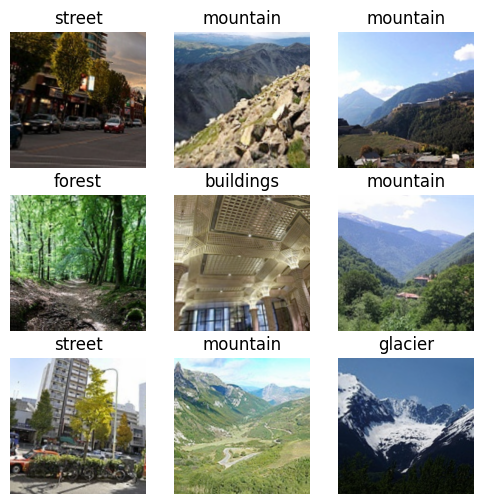

In [30]:
# sample 9 random image from dataset
dls.show_batch(max_n=9, figsize=(6,6))


In [31]:
# our classes's names
print(dls.vocab)
print(f"total number of classes: {dls.c}")


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
total number of classes: 6


In [32]:
# data block summary
dblock.summary(train_path)


Setting-up type transforms pipelines
Found 14034 items
2 datasets of sizes 11228,2806
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/seg_train/seg_train/glacier/15972.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=150x150
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/seg_train/seg_train/glacier/15972.jpg
    applying parent_label gives
      glacier
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(2)

Final sample: (PILImage mode=RGB size=150x150, TensorCategory(2))


Found 14034 items
2 datasets of sizes 11228,2806
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipel

a4 - simple model


In [33]:
# simple model training with dls and resnet18, 5 epoch
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(5)


epoch,train_loss,valid_loss,accuracy,time
0,0.546969,0.339641,0.897006,01:20


epoch,train_loss,valid_loss,accuracy,time
0,0.341208,0.236446,0.925160,01:22
1,0.259346,0.209267,0.931932,01:21
2,0.179865,0.240729,0.926230,01:24
3,0.126973,0.194306,0.939772,01:23
4,0.100603,0.194293,0.939772,01:24


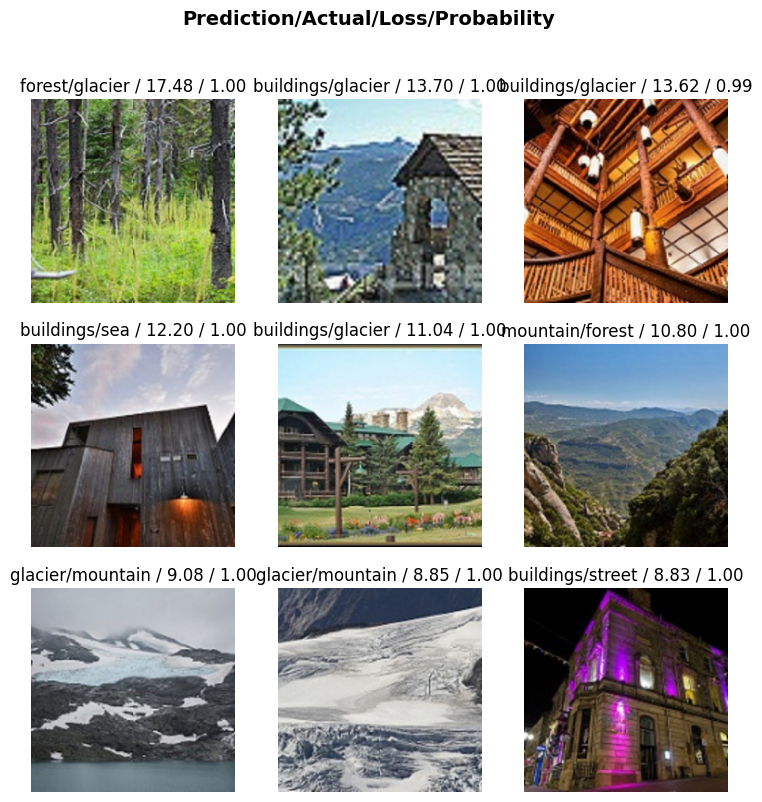

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, nrows=3)
# prediction actual loss and probability plot

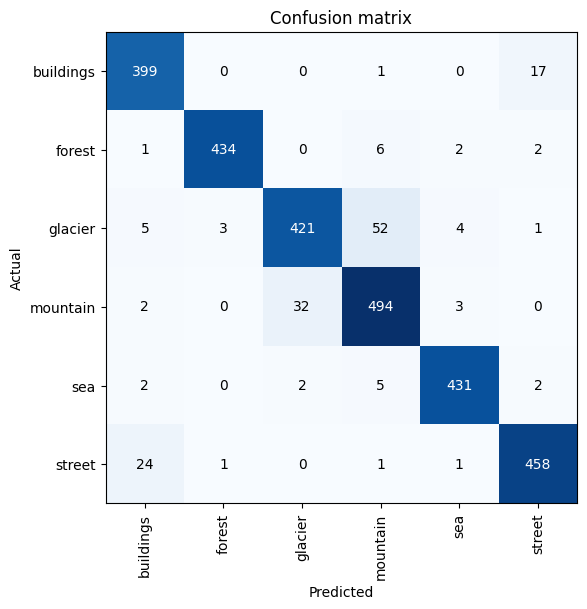

In [35]:
interp.plot_confusion_matrix(figsize=(6,6))
# confusion matrix

B.1 – Learning Rate Finder


SuggestedLRs(valley=5.248074739938602e-05)

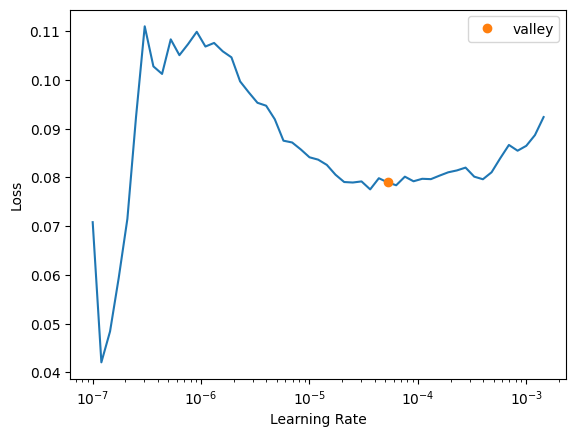

In [ ]:
#b.1.1 big lr: Convergence will be poor, if not impossible
#b.1.2 small lr: Convergence will be slow, takes too much epochs, hence overfitting

#b.1 learning rate finder
learn.lr_find()


SuggestedLRs(minimum=4.365158383734525e-06, steep=1.5848931980144698e-06, valley=9.999999747378752e-06, slide=6.30957365501672e-05)

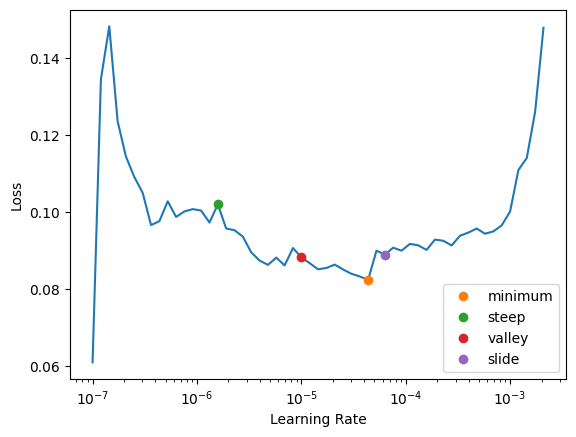

In [37]:
# different lr rates, we will choose most suitable one.
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))


In [ ]:
#b.2.5  trained the model with choosed lr rate
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(5, lr_max=2.6e-6)


epoch,train_loss,valid_loss,accuracy,time
0,3.032696,2.167092,0.220242,01:20
1,2.659628,1.847883,0.317177,01:20
2,2.453297,1.638840,0.374198,01:22
3,2.303288,1.551724,0.408054,01:21
4,2.270457,1.538323,0.410192,01:21


b3

In [ ]:
#b.3 transfer Learning
#b.3.2 freeze: train only last layer

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.freeze()  # firstly, train only new last layer
learn.fit_one_cycle(3, lr_max=1e-3)  # 3 epoch train


epoch,train_loss,valid_loss,accuracy,time
0,0.588970,0.275737,0.910905,01:21
1,0.346459,0.237696,0.922666,01:20
2,0.274834,0.220814,0.926586,01:20


In [ ]:
#b.3.3 unfreeze: train all the layers

learn.unfreeze()
learn.fit_one_cycle(5, lr_max=1e-4)


epoch,train_loss,valid_loss,accuracy,time
0,0.249284,0.236057,0.922666,01:23
1,0.226970,0.201442,0.936208,01:22
2,0.181749,0.186871,0.939772,01:22
3,0.122379,0.188964,0.939059,01:23
4,0.099831,0.187399,0.942979,01:24


b4

In [ ]:
#b.4 discriminative Learning Rates
#b.4.6–b.4.7: slice(first_lr, last_lr) → low layer low lr, higher layer high lr

learn.unfreeze()  # first opening all the layers.
learn.fit_one_cycle(5, lr_max=slice(1e-6, 1e-4))


epoch,train_loss,valid_loss,accuracy,time
0,0.091267,0.191570,0.942623,01:25
1,0.087661,0.191511,0.943336,01:24
2,0.083814,0.195806,0.941910,01:25
3,0.068371,0.200991,0.943692,01:25
4,0.076538,0.199451,0.942979,01:24


b5

In [ ]:
#b.5 – decising epoch number
#b.5.1–b.5.3: no Early stopping , with the right LR, we can do correct and full training

learn.unfreeze()
learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))


epoch,train_loss,valid_loss,accuracy,time
0,0.072860,0.198403,0.943336,01:25
1,0.066134,0.205745,0.943336,01:24
2,0.065688,0.207836,0.943692,01:26
3,0.067587,0.214059,0.944048,01:24
4,0.063046,0.215307,0.944405,01:26
5,0.052509,0.220496,0.943692,01:24
6,0.045807,0.219321,0.944048,01:24
7,0.047597,0.222316,0.944048,01:25
8,0.043343,0.224137,0.945830,01:23
9,0.042482,0.223700,0.944048,01:24


b6

In [ ]:
#b.6

# recreating the dataloaders with batchsize = 16
dls = dblock.dataloaders(Path("/content/seg_train"), bs=16)

# ResNet50
learn = vision_learner(dls, resnet50, metrics=accuracy)

# train
learn.fine_tune(5)


epoch,train_loss,valid_loss,accuracy,time
0,0.575795,0.336053,0.884890,02:04


epoch,train_loss,valid_loss,accuracy,time
0,0.360917,0.232197,0.921240,02:38
1,0.278127,0.255041,0.921953,02:38
2,0.247389,0.211275,0.935139,02:38
3,0.175635,0.293753,0.937634,02:39
4,0.143176,0.272147,0.938703,02:39


In [ ]:
#b.7 – Weight Initialization
#b.7.5: FastAI using Kaiming initialization default

import torch.nn as nn
import torch.nn.init as init

#dummy layer
layer = nn.Linear(100, 50)

# Lets start weights with Xavier manuelly
init.xavier_uniform_(layer.weight)
print("Xavier initialized weights:\n", layer.weight[:2])

# make sure of making Bias' to 0
init.zeros_(layer.bias)


Xavier initialized weights:
 tensor([[ 0.1717, -0.0609,  0.1595, -0.1641, -0.1296, -0.0595,  0.1028, -0.1262,
          0.0731,  0.1201, -0.0854,  0.1117, -0.1860,  0.1431,  0.0245,  0.1984,
          0.0176,  0.1436,  0.1880,  0.1542,  0.0815,  0.1221,  0.1683, -0.1020,
         -0.0377, -0.0089, -0.0232,  0.1575, -0.1026,  0.0493,  0.0381, -0.0179,
         -0.0844, -0.1469, -0.0295,  0.0318, -0.0053, -0.0032, -0.0277, -0.1140,
          0.1389,  0.0239,  0.1987, -0.1025, -0.0308, -0.0684, -0.0456,  0.0113,
         -0.0757,  0.0781,  0.1509,  0.1445,  0.0536, -0.0928, -0.0090,  0.0923,
          0.0671,  0.0684,  0.0844, -0.0798, -0.0620,  0.0407, -0.1354,  0.0385,
          0.1651,  0.0403,  0.1064, -0.0908,  0.0037, -0.0755,  0.0027, -0.0464,
          0.0041, -0.1865, -0.0220,  0.1643, -0.0070, -0.0901, -0.1925,  0.0275,
          0.1624, -0.0716,  0.0440,  0.0822, -0.0061,  0.0675, -0.0095, -0.0960,
          0.1898,  0.0646,  0.0154,  0.1632, -0.1587,  0.0701,  0.0886,  0.0535,

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], requires_grad=True)

c

In [47]:
learn.export("/content/model.pkl")
# model saving

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Tahmin Edilen Sınıf: street


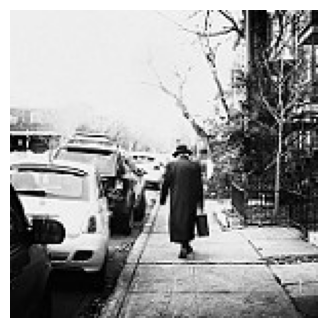

In [50]:
learn = load_learner("model.pkl")

pred_path = Path("seg_pred")
img_files = get_image_files(pred_path)
img_path = random.choice(img_files)

img = PILImage.create(img_path)
img.show(figsize=(4,4))
pred_class, pred_idx, pred_probs = learn.predict(img)

print(f"Tahmin Edilen Sınıf: {pred_class}")


Tahmin Edilen Sınıf: street


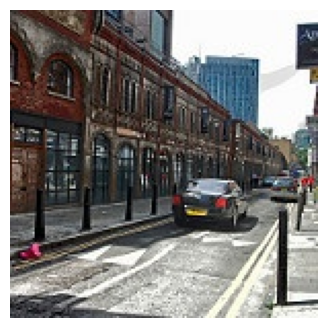

In [51]:
learn = load_learner("model.pkl")

pred_path = Path("seg_pred")
img_files = get_image_files(pred_path)
img_path = random.choice(img_files)

img = PILImage.create(img_path)
img.show(figsize=(4,4))
pred_class, pred_idx, pred_probs = learn.predict(img)

print(f"Tahmin Edilen Sınıf: {pred_class}")


Tahmin Edilen Sınıf: glacier


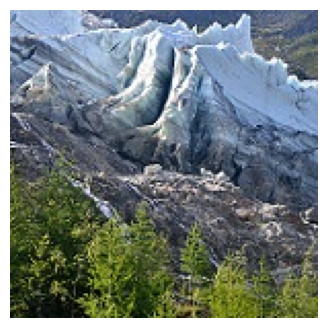

In [52]:
learn = load_learner("model.pkl")

pred_path = Path("seg_pred")
img_files = get_image_files(pred_path)
img_path = random.choice(img_files)

img = PILImage.create(img_path)
img.show(figsize=(4,4))
pred_class, pred_idx, pred_probs = learn.predict(img)

print(f"Tahmin Edilen Sınıf: {pred_class}")


In [55]:
import fastai
import torch
import torchvision
import PIL


print(f"Fastai version: {fastai.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"PIL version: {PIL.__version__}")

Fastai version: 2.7.19
PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
PIL version: 11.2.1


In [56]:
import sys

print(sys.version)

3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
